<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Step-2---define-the-descriptive-statistical-model" data-toc-modified-id="Step-2---define-the-descriptive-statistical-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Step 2 - define the descriptive statistical model</a></span><ul class="toc-item"><li><span><a href="#\begin{align*}--
\mu_\theta-&amp;\sim-Normal(0,-\sigma_\theta)-
\\-\mu_\beta-&amp;\sim-Normal(0,-\sigma_\beta)-
\\-\sigma_\theta-&amp;\sim-Normal(0,-b_{\sigma\theta})-
\\-\sigma_\beta-&amp;\sim-Normal(0,-b_{\sigma\beta})-
\\-\rho-&amp;\sim-LKJ(1)-
\\-\eta_i-&amp;\sim-MVN\bigg((\mu_\theta,-\mu_\beta),-\begin{bmatrix}-\sigma_\theta^2-&amp;\rho\sigma_\theta\sigma_\beta-
\\-\rho\sigma_\theta\sigma_\beta-&amp;-\sigma_\beta^2-
\\-\end{bmatrix}\bigg)-
\\-\hat{\theta_i}-&amp;\sim-Normal(\eta_{1i,-\sigma_{\epsilon\theta-i}})-
\\-\hat{\beta_i}-&amp;\sim-Normal(\eta_{2i,-\sigma_{\epsilon\beta-i}})
\end{align*}" data-toc-modified-id="\begin{align*}--
\mu_\theta-&amp;\sim-Normal(0,-\sigma_\theta)-
\\-\mu_\beta-&amp;\sim-Normal(0,-\sigma_\beta)-
\\-\sigma_\theta-&amp;\sim-Normal(0,-b_{\sigma\theta})-
\\-\sigma_\beta-&amp;\sim-Normal(0,-b_{\sigma\beta})-
\\-\rho-&amp;\sim-LKJ(1)-
\\-\eta_i-&amp;\sim-MVN\bigg((\mu_\theta,-\mu_\beta),-\begin{bmatrix}-\sigma_\theta^2-&amp;\rho\sigma_\theta\sigma_\beta-
\\-\rho\sigma_\theta\sigma_\beta-&amp;-\sigma_\beta^2-
\\-\end{bmatrix}\bigg)-
\\-\hat{\theta_i}-&amp;\sim-Normal(\eta_{1i,-\sigma_{\epsilon\theta-i}})-
\\-\hat{\beta_i}-&amp;\sim-Normal(\eta_{2i,-\sigma_{\epsilon\beta-i}})
\end{align*}-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><script type="math/tex; mode=display" id="MathJax-Element-147">\begin{align*}  
\mu_\theta &\sim Normal(0, \sigma_\theta) 
\\ \mu_\beta &\sim Normal(0, \sigma_\beta) 
\\ \sigma_\theta &\sim Normal(0, b_{\sigma\theta}) 
\\ \sigma_\beta &\sim Normal(0, b_{\sigma\beta}) 
\\ \rho &\sim LKJ(1) 
\\ \eta_i &\sim MVN\bigg((\mu_\theta, \mu_\beta), \begin{bmatrix} \sigma_\theta^2 &\rho\sigma_\theta\sigma_\beta 
\\ \rho\sigma_\theta\sigma_\beta & \sigma_\beta^2 
\\ \end{bmatrix}\bigg) 
\\ \hat{\theta_i} &\sim Normal(\eta_{1i, \sigma_{\epsilon\theta i}}) 
\\ \hat{\beta_i} &\sim Normal(\eta_{2i, \sigma_{\epsilon\beta i}})
\end{align*}</script></a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Import analysis packages

In [1]:
import stan as ps
import numpy as np
import os
import pandas as pd
from patsy import dmatrix
import arviz as az
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# Importing nest_asyncio is only necessary to run pystan in Jupyter Notebooks.
import nest_asyncio
nest_asyncio.apply()

# Measurement error models

The notebook here describes a measurment erro model under the Bayesian framework. As mesaurment erro models go it is not the simplest example, hoever the example here is taken from a very good journal article by Matzke et al. (2018), whom demonstrated this model using the JAGS and BUGS probabilitic programming langauges. Here a Stan version of that model is presented, with all the Stan extras like LKJ priors and non-centering as a result of the hamiltonian monte carlo sampling.

The problem of measurment error generally in psycholgical sciences is a result of our imperfect measurement tools. Of particualr concern to Matzke et al. is teh fact that measurment error can result in underestimation of correlation coefficients. Many non-Byaesian methods for correction of measurement error and their deletirious effects exist Behetsa et al. (2009). However, these methods do not carry forward uncertainty in their estimation, in the way Bayesian hierachial methods do with their shrinkage properties Behetsa et al. There example below is based on estimating the true corrletion between participant specific parameters (are the data). 

# Import the data

The following data below is the example data distrbuted for the Matske et al (2018) from this Open science foundation https://osf.io/mvz29/ used for their BUGS implementation.

In [2]:
# Import data from directory exported from RData file from origninal Win BUGS example
observed = 'https://raw.githubusercontent.com/ebrlab/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/master/wip/Data/observed.csv'
epsilon = 'https://raw.githubusercontent.com/ebrlab/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/master/wip/Data/epsilon.csv'

df1 = pd.read_csv(observed)
df2 = pd.read_csv(epsilon)

y = np.asarray(dmatrix("0 + theta + beta", data = df1) )
epsilon = np.asarray(dmatrix("0 + theta_epsilon + beta_epsilon", data = df2) )

# Step 2 - define the descriptive statistical model  


## \begin{align*}  
\mu_\theta &\sim Normal(0, \sigma_\theta) 
\\ \mu_\beta &\sim Normal(0, \sigma_\beta) 
\\ \sigma_\theta &\sim Normal(0, b_{\sigma\theta}) 
\\ \sigma_\beta &\sim Normal(0, b_{\sigma\beta}) 
\\ \rho &\sim LKJ(1) 
\\ \eta_i &\sim MVN\bigg((\mu_\theta, \mu_\beta), \begin{bmatrix} \sigma_\theta^2 &\rho\sigma_\theta\sigma_\beta 
\\ \rho\sigma_\theta\sigma_\beta & \sigma_\beta^2 
\\ \end{bmatrix}\bigg) 
\\ \hat{\theta_i} &\sim Normal(\eta_{1i, \sigma_{\epsilon\theta i}}) 
\\ \hat{\beta_i} &\sim Normal(\eta_{2i, \sigma_{\epsilon\beta i}})
\end{align*}

Lets break down this hierachial model for correlation estimation in  the presence of measurment error for as described Matske et al.(2017) with the generla methods that origninally proposed by Behesta et al (2009). The model can be genrally broken down into two levels. The first of which is the level of the observed data which it he formulation above are $(\hat{\theta_i}, \hat{\beta_i} )$ with the corresponding observederror $\sigma_{\epsilon\beta i}, \sigma_{\epsilon\beta i}$ for each observation $ i,$ $i = 1...N$

$\sigma_{\epsilon\beta i}, \sigma_{\epsilon\beta i}$ can be either assumed known or estimated from data. Of note this model does not assume homogeneity of variance, because each observation $i$ has it own associated error.

The second level is the level of all the infered variables (parameters) of the model. for each observation $i$ a $\eta$ is estimated with $\eta = (\theta_i, \beta_i)$ which a e the infered true values once error is accounted for in the model. $\rho$ is the correlation parameter between $(\theta, \beta)$ when measument error has been modelled. $(\mu_{\theta}, \mu_{\beta}, \sigma_{\theta}, \sigma_{\beta}, \rho)$ are estimated from the data and thus have priors associated with them. This where the model use here diverges from  the WinBugs implementation from Matske et al. (2007). Wihtin this implemetation or the parameter have given weaklyinformative prior values using normal disributions, wheras the Matske etal implemtation suggested very broad priors and to use uniform distributions on the $\sigma$. Final difference is with the $\rho$ prior. orignally a uniform(-1,1) is suggested following Jeffrey (1961), but Stan implemetns LKJ priors which can have same effect as uniform(-1,1) if the set to value of 1.

In [21]:
data = {'n': len(y),
'J': 2,
'y': y,
'epsilon': epsilon,
'sigma_sigma_theta': 5,
'sigma_sigma_beta': 5,
'sigma_mu_theta': 2,
'sigma_mu_beta': 2,
'cor_val': 1}

In [4]:
hier = """
data {
// Stan version of "Bayesian Inference for Correlations in the Presence of Measurement Error 
// and Estimation Uncertainty" WinBugs model

int<lower = 1> n; // Number of observations
int<lower = 1> J; // Number of groups

// Wide format data array containing 
// theta and beta observed values
vector[J] y[n];
vector[J] epsilon[n];

// Prior values must be integer as that is how ther sepcified in python
// to use real number these would need changing
int sigma_mu_theta;
int sigma_mu_beta;
int sigma_sigma_theta;
int sigma_sigma_beta;
int cor_val;
}
parameters {
  vector[J] mu;
  vector<lower = 0>[J] sigma;   
  vector[J] z[n];
  cholesky_factor_corr[J] rho;
}

transformed parameters {

 vector[J] eta[n];
 matrix[J, J] L = diag_pre_multiply(sigma, rho);
 for (i in 1:n){
  eta[i] = mu + L * z[i];
    }
}

model{

//Priors
// Hyperpriors
mu ~ normal(0, sigma_mu_theta);

sigma ~ normal(0, sigma_sigma_theta);


rho ~ lkj_corr_cholesky(cor_val);

for(i in 1:n) {
    z[i] ~ std_normal();
  }

// likelihood
for (i in 1:n){
        y[i,] ~ normal(eta[i,], epsilon[i, ]);  
    }
}

generated quantities {

  corr_matrix[J] rho_u = rho * rho';
  
}
"""

In [22]:
sm1 = ps.build(hier, data=data, random_seed=1)

Building...



Building: found in cache, done.

In [23]:
%%capture
# Using hmc_nuts_diag_e_adapt to sample the model whilst specfing 
#the step size of sampler to .95 to remove the divergent transitions.
fit = sm1.hmc_nuts_diag_e_adapt(num_chains=4, stepsize = .99)
fit_df = fit.to_frame()
az.summary(fit)

# Posterior checks

## Traceplots

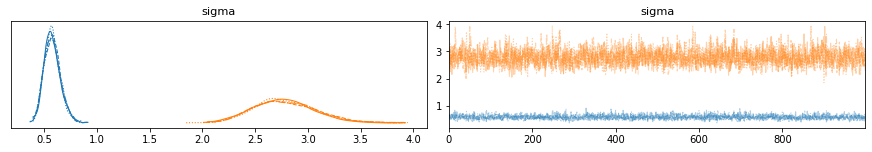

In [18]:
az.plot_trace(fit, var_names=['sigma']);

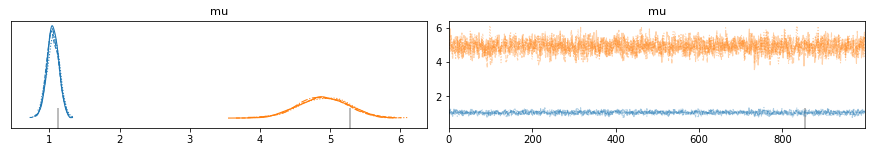

In [24]:
az.plot_trace(fit, var_names=['mu']);

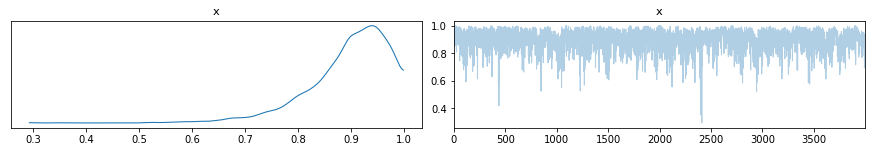

In [9]:
az.plot_trace(fit['rho_u'][0,1]);

# Posteriors

No systematic pathologies with MCMC chains and generally follow a "Fuzzy caterpillar".

In [19]:
etal1 = []
etal2 = []
for i in np.arange(len(df1)):
    eta1 = np.mean(fit['eta'][i,0])
    eta2 = np.mean(fit['eta'][i,1])
    etal1.append(eta1)
    etal2.append(eta2)

# Shrinkage

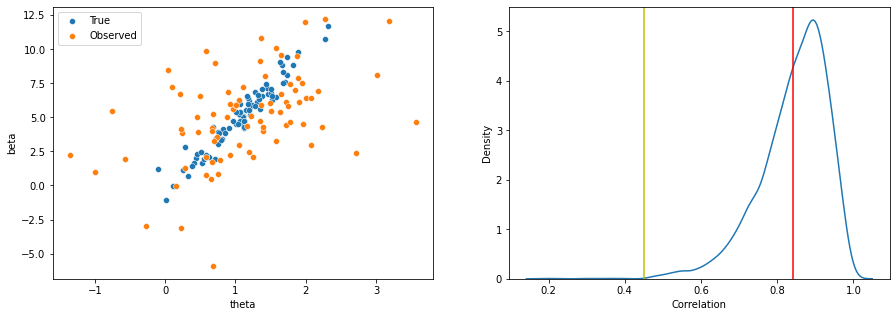

In [20]:
# Scatterplot showing the shrinkage effect from observed to infered true estimates
# after estiamting the correltion whilst accouting for the measurment errors of observed 
#values

# x coordiantes for vertical lines
xcoords = [pearsonr(df1['theta'], df1['beta'])[0], np.mean(fit['rho_u'][0,1])]
col = ('y', 'r')
legend = ['True', 'Observed']

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(ax= ax1,x = etal1, y = etal2);
sns.scatterplot(ax= ax1,x = df1['theta'], y = df1['beta']);
ax1.legend(['True', 'Observed'])

sns.kdeplot(fit['rho_u'][0,1], ax= ax2);
plt.xlabel('Correlation')

# for i in range(2):
plt.axvline(xcoords[0],color= col[0]);
plt.axvline(xcoords[1], color= col[1]);

As the plots above shows for this partiucalar (simulated example) there is a strong shrinkage effect from the observed estimates to the true value estimates. Resulting in a much larger correlation estimate for the true  estimate being >.8.

# Writing up measurment error model

The example model above is set up to be a very general implementation of hierachial measurement mode. Therfore, compared to the other notebooks there will be very little descriton of write up but a few pointers.

1. Justify the method
2. Rigoursly hustify your measurement errors 
3. Visualisation is key 
4. Stree that ery little is lost by applying this method if there is little shrinkage in the estimates it suggests accurate estimation in the first place.

# References

Behseta, S., Berdyyeva, T., Olson, C. R., & Kass, R. E. (2009). Bayesian correction for attenuation of correlation in multi-trial spike count data. Journal of neurophysiology, 101(4), 2186-2193.

Matzke, D., Ly, A., Selker, R., Weeda, W. D., Scheibehenne, B., Lee, M. D., ... & Bouwmeester, S. (2017). Bayesian inference for correlations in the presence of measurement error and estimation uncertainty. Collabra: Psychology, 3(1).